Import all the libraries we need

In [1]:
import lasio
import os
import numpy as np
import matplotlib.pyplot as plt
from math import isnan
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xg

Import all las files into las objects at once. This will save us time because the read method of lasio is much slower than just calling an already imported las object.

In [2]:
lasDic = {}
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".las"):
        lasDic[filename] = lasio.read(filename)

In [3]:
#check file versions
for filename in lasDic:
    las = lasDic[filename]
    print(las.version)

Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
VERS            2.0    CWLS log ASCII Standard -VERSION 2.0  
WRAP            NO     One line per depth step               
DLM             SPACE  Column Data Section Delimiter         
Mnemonic  Unit  Value  Description                           
--------

In [4]:
#Extract well locations
#NOTE: well locations are offset by a constant latitude/longitude to make them non-traceable
#however, their relative distance is preserved.

Lat = []
Lon = []
for filename in lasDic:
    las = lasDic[filename]
    Lat.append(las.well['SLAT'].value)
    Lon.append(las.well['SLON'].value)

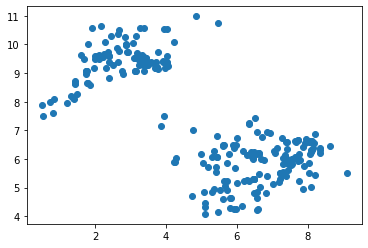

In [5]:
plt.scatter(x=Lon,y=Lat)
plt.show()

Take a look at each file mnemonic and their description.

In [6]:
for filename in lasDic:
    las = lasDic[filename]
    print(las.curves)

Mnemonic  Unit  Value  Description               
--------  ----  -----  -----------               
DEPT      F            1 MEASURED DEPTH          
GRS       GAPI         GAMMA RAY FROM SONIC LOG  
DTCO      US/F         DELTA-T COMPRESSIONAL     
DTSM      US/F         DELTA-T SHEAR             
Mnemonic  Unit  Value  Description                           
--------  ----  -----  -----------                           
DEPT      F            1 MEASURED DEPTH                      
DTCO      US/F         DELTA-T COMPRESSIONAL                 
DTST      US/F         DELTA-T STONELEY - MONOPOLE STONELEY  
DTSM      US/F         DELTA-T SHEAR                         
GRD       GAPI         GAMMA RAY FROM DENSITY LOG            
NPHI_LS   DEC          NEUTRON POROSITY LIMESTONE            
Mnemonic  Unit  Value  Description                                                
--------  ----  -----  -----------                                                
DEPT      F            1 MEASURED DEPT

TNPH_LS   DEC          THERMAL NEUTRON POROSITY [LIMESTONE]                      
Mnemonic  Unit  Value  Description                                                 
--------  ----  -----  -----------                                                 
DEPT      F                                                                        
PEF       B/E          PHOTOELECTRIC FACTOR                                        
NPHI      DEC          NEUTRON POROSITY LIMESTONE                                  
DPHI      DEC          DENSITY POROSITY SANDSTONE                                  
RHOB      G/C3         BULK DENSITY                                                
DRHO      G/C3         DENSITY CORRECTION                                          
DTCO      US/F         COMPRESSIONAL-WAVE INTERVAL TRANSIT TIME ACOUSTIC SLOWNESS  
DTSM      US/F         INTERVAL TRANSIT TIME FROM TRANSMITTER ARRAY                
DTST      US/F         DELTA T STONELEY WAVE SLOWNESS                         

Count the times each mnemonic appears in the set of all files.

In [7]:
curveCount = {}
for filename in lasDic:
    las = lasDic[filename]
    for item in las.curves.iteritems():
        if item[0] in curveCount.keys():
            curveCount[item[0]] += 1
        else:
            curveCount[item[0]] = 1

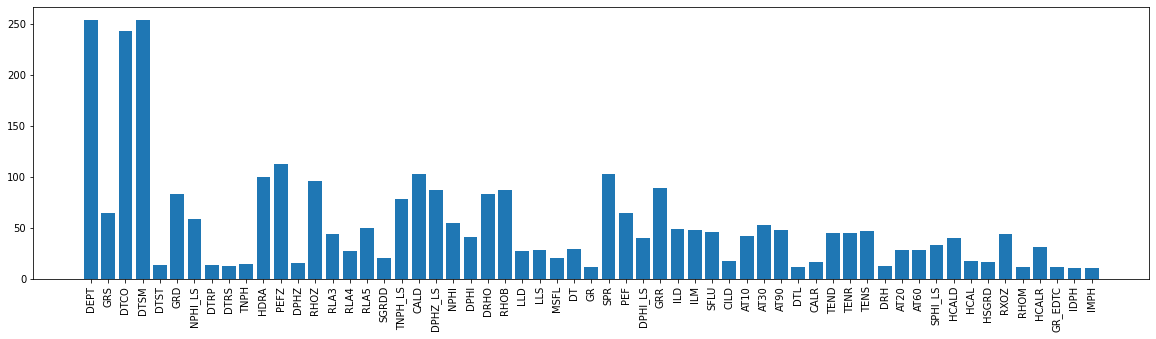

In [8]:
keys = []
for key in curveCount:
    if curveCount[key] > 10:
        keys.append(key)
values = [curveCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.show()

Instead of counting the number of times a given mnemonic appears in the entire wells dataset, we can count how many times a given unit of measurement (which is associated with a mnemonic appears). This may be useful because several mnemonics can have the same units and can possibly represent the same physical measure.

In [9]:
unitCount = {}
for filename in lasDic:
    las = lasDic[filename]
    for item in las.curves.iteritems():
        if item[1].unit in unitCount.keys():
            unitCount[item[1].unit] += 1
        else:
            unitCount[item[1].unit] = 1

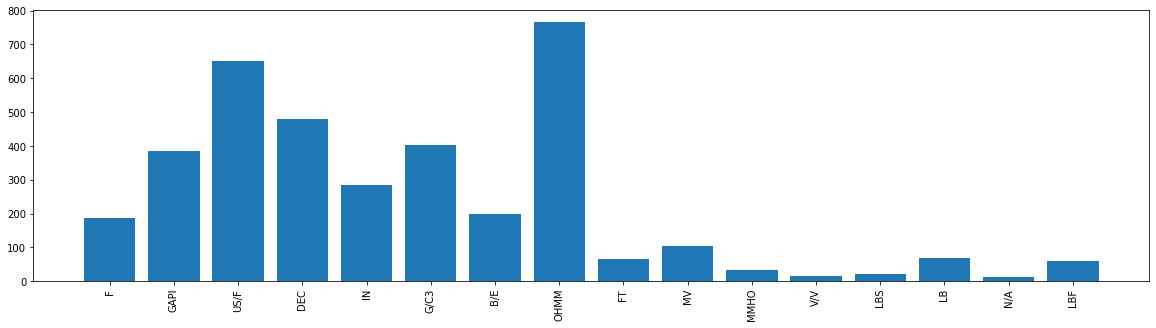

In [10]:
keys = []
for key in unitCount:
    if unitCount[key] > 10:
        keys.append(key)
values = [unitCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.show()

Alternatively, we can count how many times a unit appears in the whole dataset but counting it for every well only once.

In [11]:
unitCount = {}
for filename in lasDic:
    las = lasDic[filename]
    unitset = set()
    for item in las.curves.iteritems():
        unitset.add(item[1].unit)
    for item in unitset:
        if item in unitCount.keys():
            unitCount[item] += 1
        else:
            unitCount[item] = 1

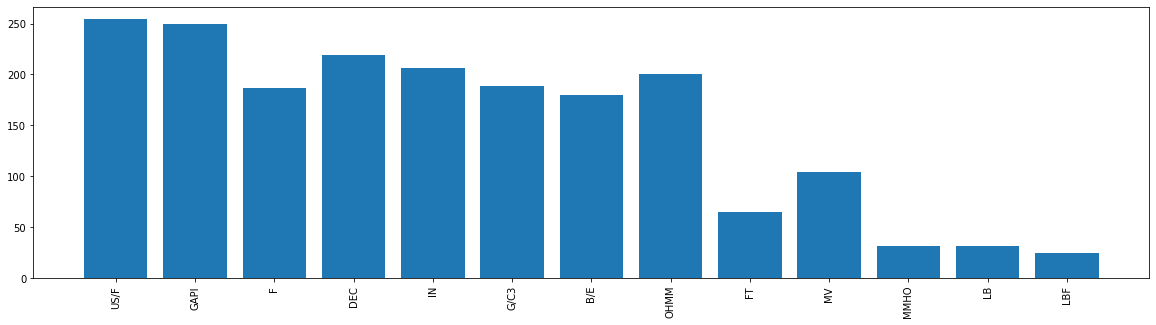

In [12]:
keys = []
for key in unitCount:
    if unitCount[key] > 10:
        keys.append(key)
values = [unitCount[key] for key in keys]
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.show()

Here we extract the actual log data from the las file.

(93.1397, 235.2891)

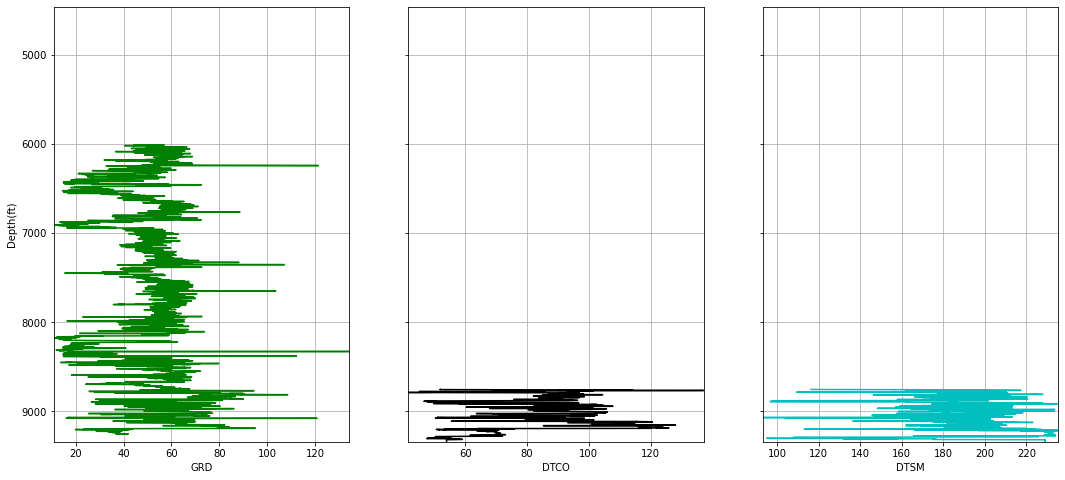

In [13]:
las = lasDic['cbe115c74a89_TGS.las']
logs = las.df()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8), sharey=True)
ax[0].plot(logs.GRD, logs.index, color='green')
ax[1].plot(logs.DTCO, logs.index, color='black')
ax[2].plot(logs.DTSM, logs.index, color='c')
for i in range(len(ax)):
    ax[i].set_ylim(logs.index[0], logs.index[-1])
    ax[i].invert_yaxis()
    ax[i].grid()

ax[0].set_xlabel("GRD")
ax[0].set_xlim(logs.GRD.min(), logs.GRD.max())
ax[0].set_ylabel("Depth(ft)")
ax[1].set_xlabel("DTCO")
ax[1].set_xlim(logs.DTCO.min(), logs.DTCO.max())
ax[2].set_xlabel("DTSM")
ax[2].set_xlim(logs.DTSM.min(), logs.DTSM.max())

We can map out how two particular mnmonics appears across all wells and across all depths. For example, we can select GRD and GRS and look to see at which wells and at what depth intervals, one of them, both of them, or none of them appear.

In [14]:
maxdepth = 25000
datamap = np.ndarray(shape=(maxdepth, len(lasDic)), dtype=int)
x1 = 'GRD'
x2 = 'GRS'
wellNo = 0
for filename in lasDic:
    print("on well: {}".format(filename))
    df = lasDic[filename].df()
    allmeasures = list(df.columns)
    for i in range(maxdepth):
        if i not in df.index:
            datamap[i,wellNo] = 0 #code for no data at all at that depth
            continue
        try:
            x1_val = df.loc[i, x1]
        except:
            x1_val = np.nan
        try:
            x2_val = df.loc[i, x2]
        except:
            x2_val = np.nan
            
        if np.isnan(x1_val) and np.isnan(x2_val):
            datamap[i,wellNo] = 1 #code for data available at the depth but not x1 or x2
        elif not np.isnan(x1_val) and  np.isnan(x2_val):
            datamap[i,wellNo] = 2 #code for only x1 available at that depth
        elif np.isnan(x1_val) and  not np.isnan(x2_val):
            datamap[i,wellNo] = 3 #code for only x2 available at that depth
        elif not np.isnan(x1_val) and  not np.isnan(x2_val):
            datamap[i,wellNo] = 4 #code for both x1 and x2 available at that depth
    wellNo += 1
            
            

on well: aaa6cb9d1317_TGS.las
on well: 5246f53b5ac1_TGS.las
on well: 11e86c424d08_TGS.las
on well: 6e79db80b34b_TGS.las
on well: 33a468d6daa8_TGS.las
on well: bd4ebda9dc29_TGS.las
on well: 8f13fbc30aa1_TGS.las
on well: 6c22c24c3e7c_TGS.las
on well: 1bff6afa48e2_TGS.las
on well: 8c261ddf84f0_TGS.las
on well: 00d02be79f49_TGS.las
on well: d6aa464fab0e_TGS.las
on well: 5875f91cc9c6_TGS.las
on well: d322975c9aaf_TGS.las
on well: 70a049901d0c_TGS.las
on well: 638f2cc65681_TGS.las
on well: ff7845ea074d_TGS.las
on well: ccfbdab3304f_TGS.las
on well: 3e09ee2f5add_TGS.las
on well: fe47e0c3ac55_TGS.las
on well: e178c20a54f5_TGS.las
on well: c18057ef2d26_TGS.las
on well: 72a148eac9f5_TGS.las
on well: bb0d54e77d0d_TGS.las
on well: 7e0ff0d533e8_TGS.las
on well: a4751745ddb7_TGS.las
on well: 5ca18d2db9c6_TGS.las
on well: 987d824173a4_TGS.las
on well: 34a80ab7a5fa_TGS.las
on well: 6cd66f018b76_TGS.las
on well: 53b73a130d0c_TGS.las
on well: b13f2e23d0b3_TGS.las
on well: 07bda346ac4d_TGS.las
on well: 4

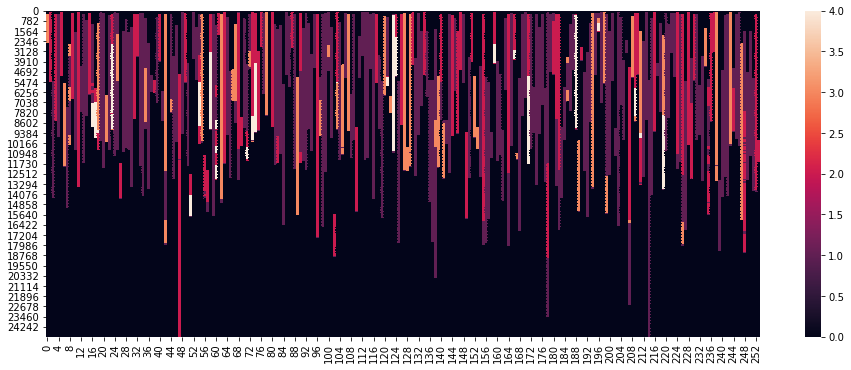

In [23]:
plt.figure(figsize=(16,6))
ax=sns.heatmap(datamap)

Here, we will go through all rows of all wells data and extract those that have both "GRD" and "GRS" listed for the same depth.

In [16]:
x1 = 'GRD'
x2 = 'GRS'
x1List = []
x2List = []
for filename in lasDic:
    allmeasures = list(lasDic[filename].df().columns)
    if x1 in allmeasures and x2 in allmeasures:
        for index, row in lasDic[filename].df().iterrows():
            x1_val = row[allmeasures.index(x1)]
            x2_val = row[allmeasures.index(x2)]
            if not isnan(x1_val) and not isnan(x2_val):
                x1List.append(x1_val)
                x2List.append(x2_val)


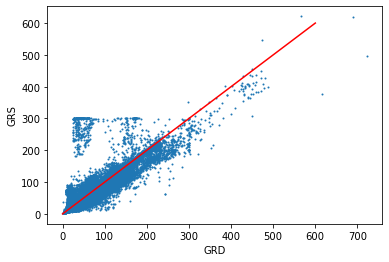

In [17]:
plt.scatter(x1List, x2List, s=1)
plt.xlabel(x1)
plt.ylabel(x2)
plt.plot([0,600],[0,600], c='r')
plt.show()

Let's gather x and y data with x being a set of mnemonics that are pretty frequently occured and y as the parameter of interest and train this with a simple xgboost regressor.

In [18]:
xlabels = ['GRD', 'DTCO', 'SPR', 'RHOB']
ylabels = ['DTSM']
x = []
y = []
for filename in lasDic:
    allmeasures = list(lasDic[filename].df().columns)
    if all([item in allmeasures for item in xlabels+ylabels]):
        for index, row in lasDic[filename].df().iterrows():
            inputs = []
            [inputs.append(row[allmeasures.index(i)]) for i in xlabels]
            outputs = []
            [outputs.append(row[allmeasures.index(i)]) for i in ylabels]
            if all([not isnan(item) for item in inputs+outputs]):
                x.append(inputs)
                y.append(outputs)
x = np.asarray(x)
y = np.asarray(y)

In [19]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.3)
xgb_r = xg.XGBRegressor(objective='reg:squarederror', n_estimators=10)
xgb_r.fit(train_x,train_y)
pred = xgb_r.predict(test_x)
rmse = np.sqrt(MSE(test_y,pred))
rmse

12.618806371836772

We can do the same thing as before except this time we allow datapoints containing NaN values for some of the features to be included in the test/train data.

In [20]:
xlabels = ['GRD', 'DTCO', 'SPR', 'RHOB']
ylabels = ['DTSM']
x = []
y = []
for filename in lasDic:
    allmeasures = list(lasDic[filename].df().columns)
    if all([item in allmeasures for item in ylabels]):
        for index, row in lasDic[filename].df().iterrows():
            inputs = []
            for i in xlabels:
                try:
                    inputs.append(row[allmeasures.index(i)])
                except:
                    inputs.append(np.nan)
            outputs = []
            [outputs.append(row[allmeasures.index(i)]) for i in ylabels]
            if all([not isnan(item) for item in outputs]):
                x.append(inputs)
                y.append(outputs)
x = np.asarray(x)
y = np.asarray(y)

In [21]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.3)
xgb_r = xg.XGBRegressor(objective='reg:squarederror', n_estimators=10)
xgb_r.fit(train_x,train_y)
pred = xgb_r.predict(test_x)
rmse = np.sqrt(MSE(test_y,pred))
rmse

22.477013799049697

In [22]:
examplelas = lasDic['5ca18d2db9c6_TGS.las']